# **Machine Learning techniques to predict stock prices and regime changes in financial markets**
<p align='center'>

## **Packages Import**


In [ ]:
import datetime
import glob
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import warnings
import xlrd

from scipy import stats
from scipy import linalg
from scipy.stats import multivariate_normal
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from google.colab import files

## **Utility functions**

In [ ]:
def sample_time_between(data, start, end):
    sample = [start <= i.strftime("%H:%M") <= end for i in data.index]
    sample_index = data.index[sample]
    return data.loc[sample_index]


def sample_time_not_between(data, start, end):
    sample = [start > i.strftime("%H:%M") or i.strftime("%H:%M") >= end for i in data.index]
    sample_index = data.index[sample]
    return data.loc[sample_index]


def extract_factors_5min(data_5min, back_period=36):
    # Data is so sparse on a 1-min basis
    # Group 1-minute level data into 5-minute basis
    data = data_5min.copy()
    vol_5m = data['Volume']
    close_5m = data['Close']
    open_5m = data['Open']
    high_5m = data['High']
    low_5m = data['Low']

    # correlation coefficient between price and volume
    # look back last 5 hrs when back_period=36
    data['cor_vol_price'] = vol_5m.rolling(back_period).corr(close_5m)

    # return sum after breaking certain level volume
    vol_standard = vol_5m.rolling(72).mean() + 2.5 * vol_5m.rolling(144).std()
    ret = close_5m.div(close_5m.shift(1)) - 1
    data['ret_break_vol'] = ret[vol_5m > vol_standard].reindex_like(ret).replace(np.NAN, 0.0)
    # range
    data['range_5m'] = ((high_5m - low_5m) / close_5m)
    # average line
    data['mv_3hrs_5'] = close_5m.rolling(36).mean()
    data['crossing_mv'] = (close_5m>data['mv_3hrs_5']).astype(int).rolling(72).sum()
    # skewness kurtosis std
    data['r_std_12hrs_5'] = ret.rolling(144).std()
    data['r_skew_12hrs_5'] = ret.rolling(144).skew()
    data['r_kurt_12hrs_5'] = ret.rolling(144).kurt()
    data['r_std_3hrs_5'] = ret.rolling(36).std()
    data['r_skew_3hrs_5'] = ret.rolling(36).skew()
    data['r_kurt_3hrs_5'] = ret.rolling(36).kurt()
    data['ret'] = ret
    return data

def prepare_other_futures(df,name):
    # in order to process other futures data to add them as predictors
    # add 10Year Treasury, Crude Oil and VIX which also have the same trading time with sp500 futures
    # And we believe they can provide information to predict sp500 futures
    data = df.copy()
    data['Date'] = data['Date'].apply(lambda x: xlrd.xldate_as_datetime(x, 0))
    data['DateTimeExchange'] = data['DateTimeExchange'].apply(lambda x: xlrd.xldate_as_datetime(x, 0))
    data['DateTimeLocal'] = data['DateTimeLocal'].apply(lambda x: xlrd.xldate_as_datetime(x, 0))
    data = data.drop(columns=['Date', 'DateTimeExchange', 'Time2', 'Hour', 'Min'])
    data = data.set_index('DateTimeLocal')
    data1 = data.filter(like='1')
    data1.columns = ['Symbol', 'Name', 'Price', 'CumVolume']
    data1 = sample_time_not_between(data1, '17:00', '18:00')
    data1['Volume'] = data1['CumVolume'].diff()
    # reset its CumVolume at certain time.
    data1.dropna(inplace=True)
    data1['Volume'] = data1['Volume'].replace(0.0, np.NAN)
    data1['Volume'] = np.where(data1['Volume'] < 0, 0, data1['Volume'])
    data1.dropna(inplace=True)
    # Get the OHLC Vwap on a 5-minute basis.
    Volume_1 = data1['Volume'].resample('5min').sum().dropna()
    Close_1 = data1['Price'].resample('5min').last().dropna().rename('Close')
    Open_1 = data1['Price'].resample('5min').first().dropna().rename('Open')
    High_1 = data1['Price'].resample('5min').max().dropna().rename('High')
    Low_1 = data1['Price'].resample('5min').min().dropna().rename('Low')
    Vp = (data1['Price'] * data1['Volume']).resample('5min').sum()
    Vwap_1 = pd.DataFrame(Vp.div((Volume_1.replace(0, 1))), columns=['Vwap'])
    ret = Close_1.div(Close_1.shift(1))-1
    ret.rename(name+'_ret',inplace = True)
    Close_1.rename(name+'_close',inplace=True)
    return ret,Close_1

def sharpe(ret):
    nonneg_ret = ret.iloc[ret.to_numpy().nonzero()]
    sharpe = np.mean(nonneg_ret)/np.std(nonneg_ret)
    return sharpe

def backtest(signal_in_sample,signal_out_sample,title,mxd = False,display=False):
    # Evaluate the performance of classifiers by using predictions as trading signal
    # Use long only strategy (Hold long position when prediction is positive)
    split_date = signal_out_sample.index[0]
    signal_total = pd.concat([signal_in_sample,signal_out_sample])
    new_ret = pd.merge(signal_total,feature_futures_5min[['ret']],left_index=True,right_index=True)
    new_ret['signal'] = new_ret['signal'].shift(1)
    new_ret['returns'] = new_ret['signal']*new_ret['ret']
    new_ret['returns'] = new_ret['returns'].fillna(0)
    cumret = (new_ret['returns']+1).cumprod()-1
    returns_in = new_ret['returns'][:split_date]
    returns_out = new_ret['returns'][split_date:]
    cum_return_in = cumret[:split_date]
    cum_return_out = cumret[split_date:]
    plt.figure(figsize=(16,9))
    plt.plot(cum_return_in)
    plt.plot(cum_return_out)
    max_draw_down_in = np.min(cum_return_in-cum_return_in.cummax())
    max_draw_down_out = np.min(cum_return_out-cum_return_out.cummax())
    down_in = np.argmin(cum_return_in-cum_return_in.cummax())
    down_out = np.argmin(cum_return_out-cum_return_out.cummax())
    flag1 = cum_return_in.index[down_in]
    up_limit = max((new_ret['returns']+1).cumprod()-1)
    down_limit = min((new_ret['returns']+1).cumprod()-1)
    flag2 = cum_return_out.index[down_out]
    if mxd:
      plt.vlines(flag1,down_limit,up_limit,colors= 'r',linestyles='dashed',label='Max_drawdown for train')
      plt.vlines(flag2,down_limit,up_limit,colors= 'y',linestyles='dashed',label='Max_drawdown for test')
      plt.legend()
    # Calculate Sharpe Ratio using non-zero returns
    sharp_in_sample = sharpe(returns_in)
    sharp_out_sample = sharpe(returns_out)
    plt.title(title)
    if display:
      print('Max drawdown in sample',max_draw_down_in)
      print('Max drawdown out sample',max_draw_down_out)
      print('Sharpe in sample:',sharp_in_sample)
      print('Sharpe out sample:',sharp_out_sample)


## **Data Preprocessing**

In [ ]:
# set working directory
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Cost2 project/Cost 2/Data'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1AZqLDpNIpIqtEgayXTMxDEkvjHIyQf_i/Cost 2/Data


###Load E-Mini S&P 500 Futures Data

In [ ]:
# read the SP500 futures data from csv file
data = pd.read_csv("Mini.csv")
data.head()

,Date,DateTimeExchange,DateTimeLocal,Time2,Hour,Min,Symbol1,Symbol1_name,Price1,CumVolume1,Symbol2,Symbol2_name,Price2,CumVolume2,DistanceSwitch
0,44377,44376.958333,44377.000000,44377.000000,0,0,96,ESU21,4287.50,24436,97,ESZ21,4275.5,5102,9999
1,44377,44376.959028,44377.000694,44377.000694,0,1,96,ESU21,4287.25,24509,97,ESZ21,4275.5,5102,9999
2,44377,44376.959722,44377.001389,44377.001389,0,2,96,ESU21,4287.00,24567,97,ESZ21,4275.5,5102,9999
3,44377,44376.960417,44377.002083,44377.002083,0,3,96,ESU21,4287.00,24651,97,ESZ21,4275.5,5102,9999
4,44377,44376.961111,44377.002778,44377.002778,0,4,96,ESU21,4287.25,24695,97,ESZ21,4275.5,5102,9999


In [ ]:
# format the 'Date', 'DateTimeExchange', 'DateTimeLocal' columns
# covert excel serial date into datetime object
data['Date'] = data['Date'].apply(lambda x: xlrd.xldate_as_datetime(x, 0))
data['DateTimeExchange'] = data['DateTimeExchange'].apply(lambda x: xlrd.xldate_as_datetime(x, 0))
data['DateTimeLocal'] = data['DateTimeLocal'].apply(lambda x: xlrd.xldate_as_datetime(x, 0))

In [ ]:
# drop duplicate columns and split into 2 parts based on 'Symbol'
# 'Symbol1' and 'Symbol2' are the front and the second contract traded in the futures market
data = data.drop(columns=['Time2', 'Date', 'DateTimeExchange', 'Hour', 'Min'])
data = data.set_index('DateTimeLocal')
data1 = data.filter(like='1')
data2 = data.filter(like='2')
data2 = data2[data2['Symbol2'] != -1]
data1.columns = ['Symbol', 'Name', 'Price', 'CumVolume']
data2.columns = ['Symbol', 'Name', 'Price', 'CumVolume']
data_s1 = {}
data_s2 = {}
# print(data1.head())
# print(data2.head())

In [ ]:
# Keep front contract only ('Symbol1')
# Drop the data during non trading hours and holidays
data1 = sample_time_not_between(data1, '17:00', '18:00')
sample = ['21-12-23 18:00' > i.strftime("%y-%m-%d %H:%M") or \
          i.strftime("%y-%m-%d %H:%M") >= '21-12-26 18:00' for i in data1.index]
sample_index = data1.index[sample]
data1 = data1.loc[sample_index]
data1['Volume'] = data1['CumVolume'].diff()
data1.dropna(inplace=True)

# Drop invalid observations
data1['Volume'] = data1['Volume'].replace(0.0, np.NAN)
data1['Volume'] = np.where(data1['Volume'] < 0, 0, data1['Volume'])
data1.dropna(inplace=True)

# Group 1-minute level data into 5-minute basis
# Get the OHLC and VWAP for 5-minute data
Volume_1 = data1['Volume'].resample('5min').sum().dropna()
Open_1 = data1['Price'].resample('5min').first().dropna().rename('Open')
High_1 = data1['Price'].resample('5min').max().dropna().rename('High')
Low_1 = data1['Price'].resample('5min').min().dropna().rename('Low')
Close_1 = data1['Price'].resample('5min').last().dropna().rename('Close')
Vp = (data1['Price'] * data1['Volume']).resample('5min').sum()
Vwap_1 = pd.DataFrame(Vp.div((Volume_1.replace(0, 1))), columns=['Vwap'])
data_1_5min = pd.concat([Volume_1, Close_1, Open_1, High_1, Low_1, Vwap_1], axis=1).dropna()

# Extract features from 5-minute data using helper functions
feature_futures_5min = extract_factors_5min(data_1_5min).dropna()

In [ ]:
feature_futures_5min.head()

,Volume,Close,Open,High,Low,Vwap,cor_vol_price,ret_break_vol,range_5m,mv_3hrs_5,crossing_mv,r_std_12hrs_5,r_skew_12hrs_5,r_kurt_12hrs_5,r_std_3hrs_5,r_skew_3hrs_5,r_kurt_3hrs_5,ret
DateTimeLocal,,,,,,,,,,,,,,,,,,
2021-06-30 12:00:00,5064.0,4284.25,4285.25,4285.25,4284.25,4284.810476,0.154492,0.0,0.000233,4283.430556,56.0,0.000292,-0.108644,1.584987,0.000357,0.393302,-0.441633,-0.000233
2021-06-30 12:05:00,3983.0,4284.50,4285.25,4285.25,4284.50,4284.992405,0.081242,0.0,0.000175,4283.645833,57.0,0.000292,-0.112742,1.582625,0.000352,0.346571,-0.366429,0.000058
2021-06-30 12:10:00,3397.0,4285.25,4284.75,4285.50,4284.75,4285.114513,-0.015903,0.0,0.000175,4283.916667,58.0,0.000292,-0.123311,1.561372,0.000348,0.271607,-0.302957,0.000175
2021-06-30 12:15:00,5313.0,4286.25,4285.75,4286.25,4285.50,4285.806889,-0.147628,0.0,0.000175,4284.208333,59.0,0.000293,-0.135570,1.525572,0.000349,0.228183,-0.355703,0.000233
2021-06-30 12:20:00,6247.0,4284.75,4286.00,4286.00,4284.75,4285.312310,-0.337882,0.0,0.000292,4284.472222,59.0,0.000294,-0.120235,1.446536,0.000354,0.230084,-0.457833,-0.000350


In [ ]:
feature_futures_5min.describe()

,Volume,Close,Open,High,Low,Vwap,cor_vol_price,ret_break_vol,range_5m,mv_3hrs_5,crossing_mv,r_std_12hrs_5,r_skew_12hrs_5,r_kurt_12hrs_5,r_std_3hrs_5,r_skew_3hrs_5,r_kurt_3hrs_5,ret
count,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000,70067.000000
mean,5456.494355,4402.847271,4402.860120,4404.038766,4401.660614,4402.785935,-0.063409,-0.000004,0.000550,4402.942070,38.135727,0.000634,-0.052502,4.362054,0.000593,-0.014052,1.507097,-0.000001
std,9476.556751,232.522173,232.515967,232.204916,232.837631,233.113171,0.385543,0.000378,0.000604,232.266022,17.655226,0.000389,0.995102,6.393040,0.000449,0.836127,2.743245,0.000744
min,0.000000,3641.250000,3643.250000,3646.500000,3641.250000,0.000000,-0.964653,-0.013245,0.000000,3662.659722,0.000000,0.000104,-9.062807,-0.515932,0.000061,-5.500217,-1.440597,-0.022429
25%,611.000000,4311.750000,4311.750000,4313.250000,4310.500000,4311.737863,-0.356813,0.000000,0.000176,4312.277778,25.000000,0.000338,-0.447254,1.464819,0.000277,-0.455116,-0.011257,-0.000233
50%,1444.000000,4431.750000,4431.500000,4432.750000,4430.250000,4431.614156,-0.082912,0.000000,0.000361,4431.590278,39.000000,0.000532,-0.024632,2.709461,0.000461,-0.021357,0.749864,0.000000
75%,6542.000000,4557.000000,4557.000000,4558.250000,4555.750000,4557.067973,0.224417,0.000000,0.000688,4556.864583,52.000000,0.000844,0.401528,4.797684,0.000770,0.414287,1.995118,0.000262
max,250340.000000,4807.250000,4806.750000,4807.250000,4806.500000,4806.729545,0.945938,0.012447,0.027380,4802.541667,72.000000,0.002293,5.467098,99.233850,0.004000,4.737042,32.032283,0.012447


In [ ]:
# data1[data1.index>='2022-02-10 08:29'].tail(10)

### Simulate a random walk time series

In [ ]:
# Using Milstein

def random_walk(sig,mu,n_period,s0):
  s = s0
  # np.random.seed(0)
  z = np.random.randn(n_period)
  dt = 1/n_period
  path = [s]
  for i in range(n_period):
      # Milstein
      s = s + mu*s*dt + sig*s*np.sqrt(dt)*z[i] + 0.5*sig*sig*s*dt*(z[i]**2 - 1)
      path.append(s)
  return path
n = len(feature_futures_5min)-1
rand_walk = pd.DataFrame(index=feature_futures_5min.index)
sig = .15
mu = 0
s0 = feature_futures_5min.iloc[0]['Close']
rand_walk['Price'] = random_walk(sig,mu,n,s0)
rand_walk

,Price
DateTimeLocal,
2021-06-30 12:00:00,4284.250000
2021-06-30 12:05:00,4283.459957
2021-06-30 12:10:00,4284.753686
2021-06-30 12:15:00,4284.572451
2021-06-30 12:20:00,4283.156351
...,...
2022-06-24 16:35:00,4658.767637
2022-06-24 16:40:00,4660.853156
2022-06-24 16:45:00,4662.196990


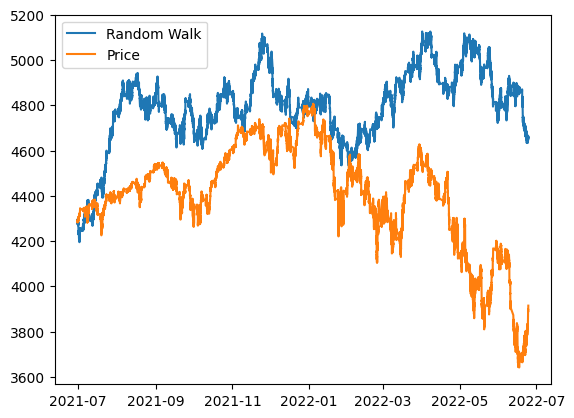

In [ ]:
plt.plot(rand_walk,label='Random Walk')
plt.plot(feature_futures_5min.Close,label='Price')
plt.legend()
plt.show()
#assessing how closely the random walk simulation matches the actual price movements of the asset.
#It can provide insights into the effectiveness of the simulation model
# and its suitability for financial analysis or predictive modeling.

###Adding futures data as features

In [ ]:
def read_futures_data():
    """
    This function reads the data of 18 futures and returns
    a dictionary containing the data of each future.

    Returns:
    dict: A dictionary containing the data of each future.
    """
    # Get the current working directory
    path = os.getcwd()
    # print(path)
    # print(os.path.join(path, "*.csv"))
    # Find all the csv files in the data folder
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    # print(csv_files)
    # Read all the futures data and save each dataframe under its name
    futures = dict()
    rets = dict()
    close = dict()
    for f in csv_files:
        name = f.split('/')[-1].split('.')[0]
        futures[name] = pd.read_csv(f)
        rets[name], close[name] = prepare_other_futures(futures[name], name)
    return futures, rets, close

In [ ]:
futures, rets, close = read_futures_data()

In [ ]:
name = input("Enter names of Future: ")

Enter names of Future: Gold


In [ ]:
def preprocess_fin(names, feature_futures_5min):
    """
    Preprocesses financial data for futures trading by merging dataframes,
    dropping invalid data, and downloading prepared data for future use.

    Args:
    names: list of string - the names of the financial data
    feature_futures_5min: pandas dataframe - the financial data

    Returns:
    feature_futures_5min: pandas dataframe - the preprocessed financial data
    """
    # merge dataframes
    for name in names.split():
        name = name.strip()

        feature_futures_5min = pd.merge(feature_futures_5min,rets[name],left_index=True,right_index=True,how='left')

    # select data with valid time
    sample = [i.strftime("%H:%M") != '18:00' for i in feature_futures_5min.index]
    sample_index = feature_futures_5min.index[sample]
    feature_futures_5min=feature_futures_5min.loc[sample_index]

    # drop invalid data
    feature_futures_5min.dropna(inplace=True)

    # download prepared data for future use
    feature_futures_5min.to_csv('/content/drive/My Drive/feature_futures_5min.csv', encoding = 'utf-8-sig')

    return feature_futures_5min


In [ ]:
feature_futures_5min = preprocess_fin(name, feature_futures_5min)
feature_futures_5min

,Volume,Close,Open,High,Low,Vwap,cor_vol_price,ret_break_vol,range_5m,mv_3hrs_5,crossing_mv,r_std_12hrs_5,r_skew_12hrs_5,r_kurt_12hrs_5,r_std_3hrs_5,r_skew_3hrs_5,r_kurt_3hrs_5,ret,Gold_ret
DateTimeLocal,,,,,,,,,,,,,,,,,,,
2021-06-30 12:00:00,5064.0,4284.25,4285.25,4285.25,4284.25,4284.810476,0.154492,0.0,0.000233,4283.430556,56.0,0.000292,-0.108644,1.584987,0.000357,0.393302,-0.441633,-0.000233,0.000510
2021-06-30 12:05:00,3983.0,4284.50,4285.25,4285.25,4284.50,4284.992405,0.081242,0.0,0.000175,4283.645833,57.0,0.000292,-0.112742,1.582625,0.000352,0.346571,-0.366429,0.000058,0.000623
2021-06-30 12:10:00,3397.0,4285.25,4284.75,4285.50,4284.75,4285.114513,-0.015903,0.0,0.000175,4283.916667,58.0,0.000292,-0.123311,1.561372,0.000348,0.271607,-0.302957,0.000175,0.000339
2021-06-30 12:15:00,5313.0,4286.25,4285.75,4286.25,4285.50,4285.806889,-0.147628,0.0,0.000175,4284.208333,59.0,0.000293,-0.135570,1.525572,0.000349,0.228183,-0.355703,0.000233,-0.000283
2021-06-30 12:20:00,6247.0,4284.75,4286.00,4286.00,4284.75,4285.312310,-0.337882,0.0,0.000292,4284.472222,59.0,0.000294,-0.120235,1.446536,0.000354,0.230084,-0.457833,-0.000350,-0.000057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24 16:35:00,1369.0,3908.75,3909.00,3909.50,3908.75,3909.041088,0.441184,0.0,0.000192,3898.722222,69.0,0.000871,3.211472,21.381134,0.000541,0.879745,1.391789,-0.000128,0.000000
2022-06-24 16:40:00,1300.0,3908.00,3909.25,3909.25,3908.00,3908.619808,0.408722,0.0,0.000320,3899.152778,69.0,0.000872,3.215393,21.370862,0.000533,1.024055,1.846359,-0.000192,0.000164
2022-06-24 16:45:00,2505.0,3907.75,3908.25,3908.25,3906.50,3907.437226,0.382549,0.0,0.000448,3899.638889,69.0,0.000871,3.216696,21.405022,0.000520,1.079724,2.103530,-0.000064,0.000000


In [ ]:
feature_futures_5min.columns

Index(['Volume', 'Close', 'Open', 'High', 'Low', 'Vwap', 'cor_vol_price',
       'ret_break_vol', 'range_5m', 'mv_3hrs_5', 'crossing_mv',
       'r_std_12hrs_5', 'r_skew_12hrs_5', 'r_kurt_12hrs_5', 'r_std_3hrs_5',
       'r_skew_3hrs_5', 'r_kurt_3hrs_5', 'ret', 'Gold_ret'],
      dtype='object')

## **Data Visualization**


###Heatmap

In [ ]:
def count_nonzero_returns(target):
    """
    This function counts the number of periods of positive and negative returns.

    Args:
      target (DataFrame): DataFrame containing the 'ret' column representing returns.

    Returns:
      DataFrame: Counts of positive and negative returns.

    """
    target = (target['ret']>0).astype(int)
    return target.value_counts()

In [ ]:
count_nonzero_returns(feature_futures_5min)

0    36496
1    32216
Name: ret, dtype: int64

In [ ]:
def visualize_correlation_heatmap(df):
    """
    Visualize the correlations between all features in a DataFrame using a heatmap.

    Args:
        df (DataFrame): Input DataFrame containing the features.

    Returns:
        None
    """
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix)

    plt.title('Correlation Heatmap')
    plt.show()

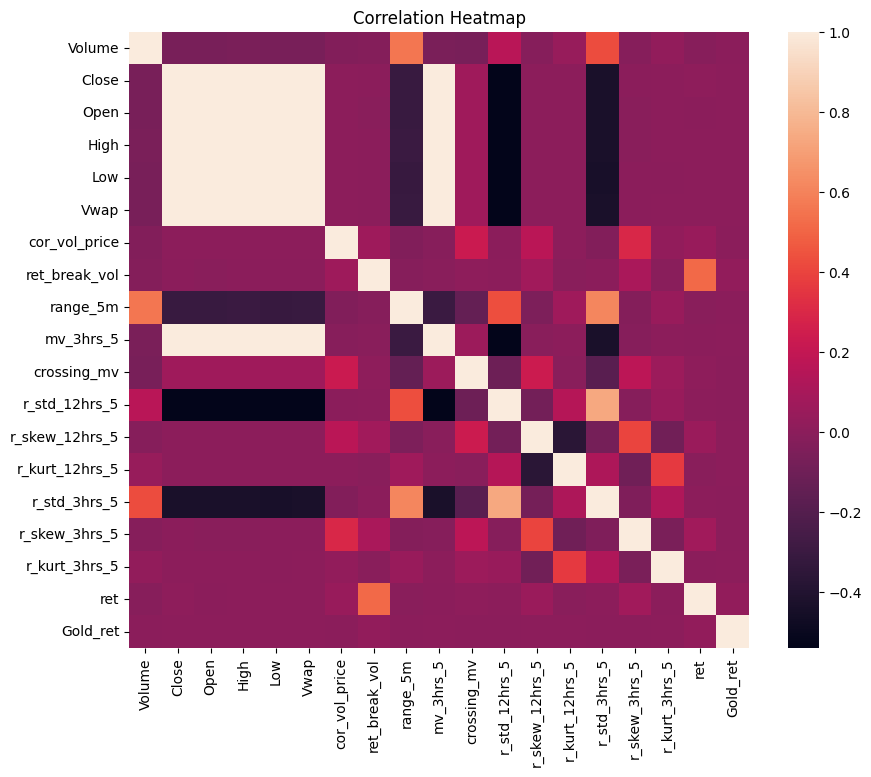

In [ ]:
visualize_correlation_heatmap(feature_futures_5min)

### Time Series Plots

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_futures_5min(feature_futures_5min, name):
    """
    Plots various features of 5-minute futures data.

    Parameters:
    - feature_futures_5min (pandas.DataFrame): a DataFrame containing the 5-minute futures data.
    - name (str): a Python string containing the name(s) of the futures used as features

    Returns: None
    """

    # Plot cumulative returns of VIX, crude oil, gold, and mini futures
    for n in name.split():
      plt.plot((feature_futures_5min[n.replace(' ', '') + '_ret']+1).cumprod()-1,label=n)

    plt.plot((feature_futures_5min['ret']+1).cumprod()-1,label='Mini')
    plt.legend()
    plt.title('Cumulative Returns')
    plt.ylabel('Return')
    plt.xlabel('Time')
    plt.show()

    # Plot 5-minute price range of SP500 futures
    feature_futures_5min['range_5m'].plot(title='5-min Price Range of E-Mini').set_ylabel('Price Range')
    plt.show()

    # Plot 5-minute correlation of volume and price of SP500 futures
    feature_futures_5min['cor_vol_price'].plot(title='5-min Correlation between Volume and Price of E-Mini').set_ylabel('Correlation')
    plt.show()

    # Plot 5-minute volume of SP500 futures
    volume_5min = feature_futures_5min['Volume']
    volume_5min.plot(title='5-minute Volume of E-Mini').set_ylabel('Volume')
    plt.show()

    # Plot 5-minute returns of SP500
    return_5min = feature_futures_5min['ret']
    return_5min.plot(title='5-min Return of E-Mini Futures').set_ylabel('Return')
    plt.show()

    # Plot 5-minute returns of Crude Oil, Gold, and/or VIX features
    for n in name.split():
      return_5min = feature_futures_5min[n.replace(' ', '') + '_ret']
      return_5min.plot(title='5-min Return of' + n + 'Futures').set_ylabel('Return')
      plt.show()

    # Plot standard deviation of 5-minute returns of SP500 futures in the past 3 hours
    feature_futures_5min['r_std_3hrs_5'].plot(title='Std of 5-min Return of E-Mini futures in 3 hours').set_ylabel('Return')
    plt.show()

    # Plot 5-minute returns of SP500 futures when it breaks certain volume
    feature_futures_5min['ret_break_vol'].plot(title='5-min Return of SP500 Futures when Break Certain Volume').set_ylabel('Return')
    plt.show()

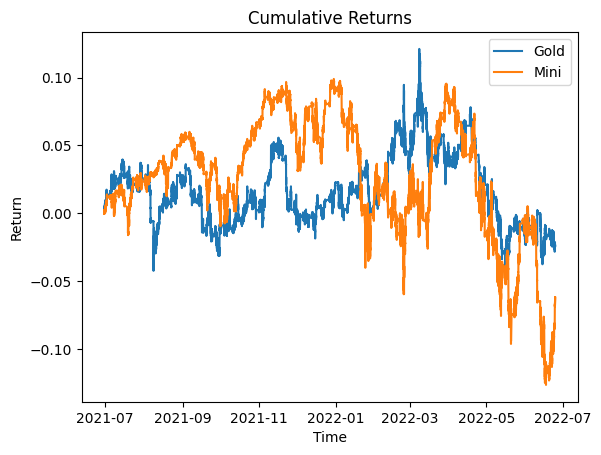

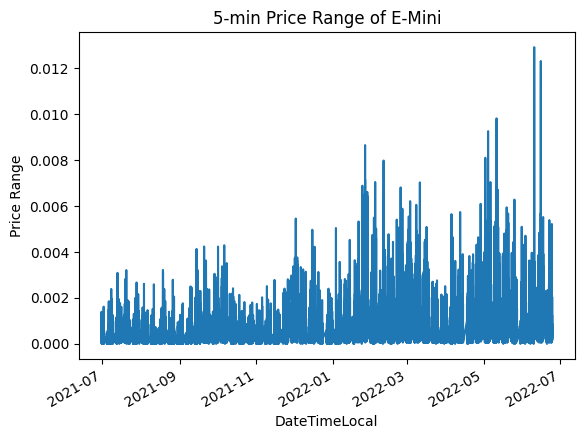

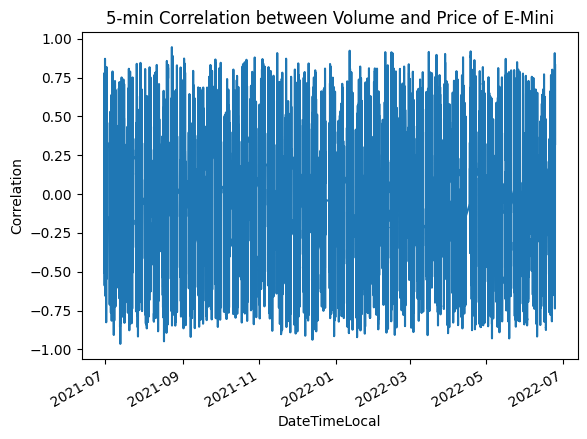

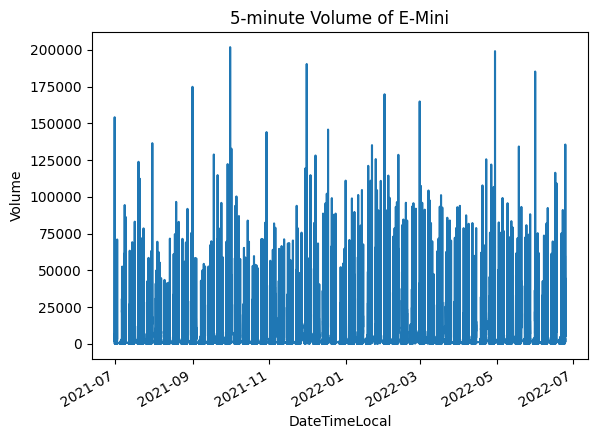

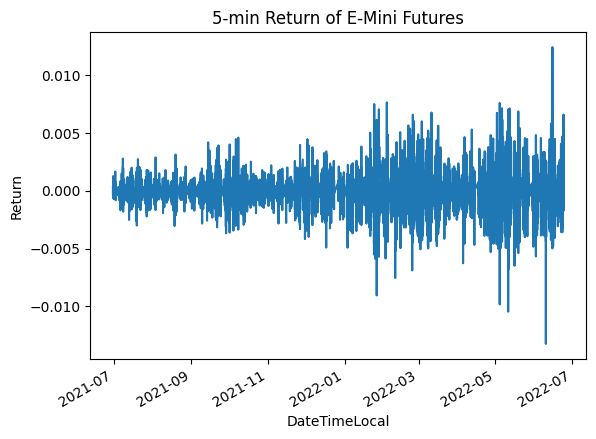

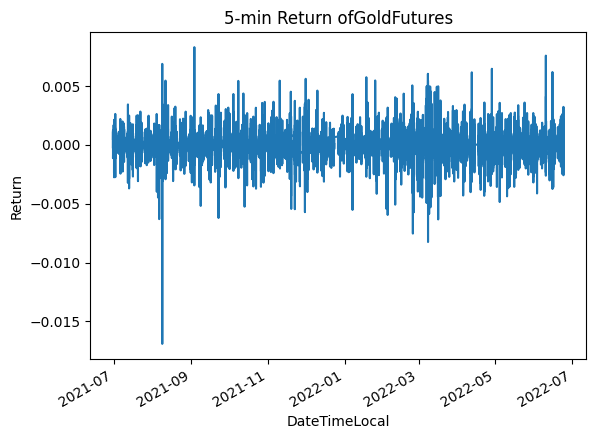

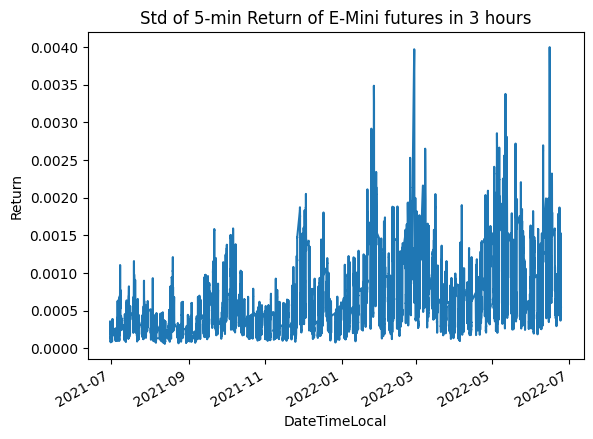

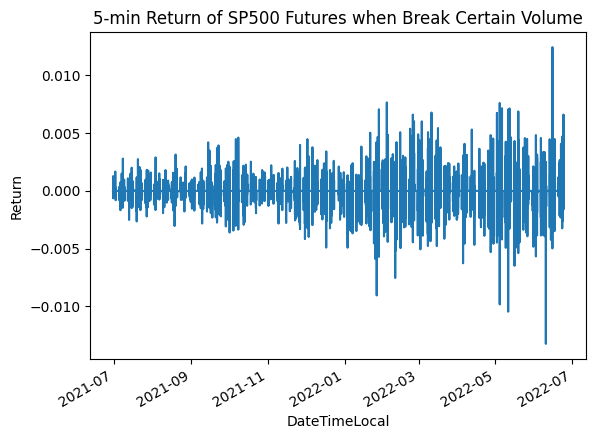

In [ ]:
plot_feature_futures_5min(feature_futures_5min, name)

### Histogram Plots


In [ ]:
def plot_histograms(feature_futures_5min, name):
    """
    Plots histograms of returns for S&P500 Mini, and selected feature

    Parameters:
    - feature_futures_5min (pandas.DataFrame): a DataFrame containing the 5-minute futures data.
    - name (str): a Python string containing the name(s) of the futures used as features

    Returns: None
    """

    # Plot the histogram of returns for each asset
    assets = ['SP500']
    returns = ['ret']

    for n in name.split():
      assets.append(n)
      returns.append(n.replace(' ', '') + '_ret')

    for i, asset in enumerate(assets):
        plt.hist(feature_futures_5min[returns[i]], bins=50)
        plt.title(f'5-min Returns of {asset}')
        plt.xlabel('Return')
        plt.ylabel('Occurance')
        plt.show()

    # Plot the four histograms in one for better comparison
    for n in name.split():
      plt.hist([feature_futures_5min['ret'], feature_futures_5min[n.replace(' ', '') + '_ret']],
             bins=50, label=['SP500', n])

    plt.legend(loc='upper right')
    plt.title('5min Returns')
    plt.xlabel('Return')
    plt.ylabel('Occurance')
    plt.show()

    # Zoom in for a closer look
    for n in name.split():
      plt.hist([feature_futures_5min['ret'], feature_futures_5min[n.replace(' ', '') + '_ret']],
             bins=np.linspace(-0.02, 0.02, 10), label=['SP500', n])

    plt.legend(loc='upper right')
    plt.title('5min Returns')
    plt.xlabel('Return')
    plt.ylabel('Occurance')
    plt.show()


# Example usage:
"""
# Load data
df = pd.read_csv('data.csv')
# Call function
plot_histograms(df, name)

# Unit test class
class TestPlotHistograms(unittest.TestCase):
    def setUp(self):
        self.df = pd.DataFrame({'ret': [0.001, 0.002, -0.001, -0.002],
                                'VIX_ret': [0.003, 0.002, -0.004, -0.001],
                                'Gold_ret': [0.002, 0.001, -0.002, -0.003],
                                'CrudeOil_ret': [-0.001, 0.003, -0.003, 0.001]})

    def test_plot_histograms(self):
        # Test that the function runs without errors
        plot_histograms(self.df)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)
"""

"\n# Load data\ndf = pd.read_csv('data.csv')\n# Call function\nplot_histograms(df, name)\n\n# Unit test class\nclass TestPlotHistograms(unittest.TestCase):\n    def setUp(self):\n        self.df = pd.DataFrame({'ret': [0.001, 0.002, -0.001, -0.002],\n                                'VIX_ret': [0.003, 0.002, -0.004, -0.001],\n                                'Gold_ret': [0.002, 0.001, -0.002, -0.003],\n                                'CrudeOil_ret': [-0.001, 0.003, -0.003, 0.001]})\n\n    def test_plot_histograms(self):\n        # Test that the function runs without errors\n        plot_histograms(self.df)\n\nif __name__ == '__main__':\n    unittest.main(argv=['first-arg-is-ignored'], exit=False)\n"

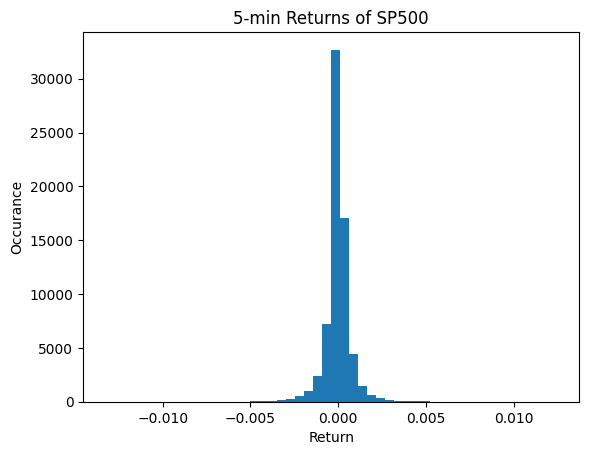

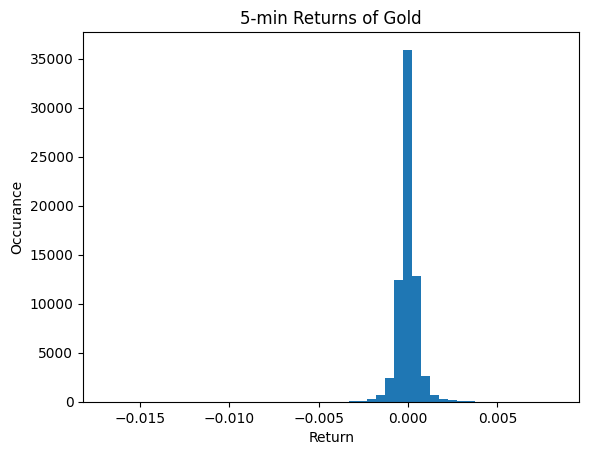

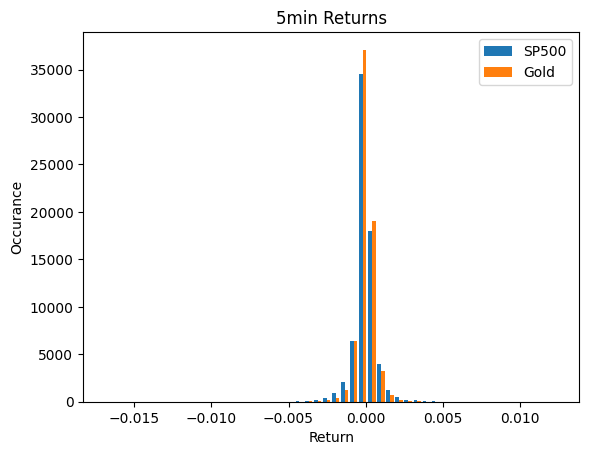

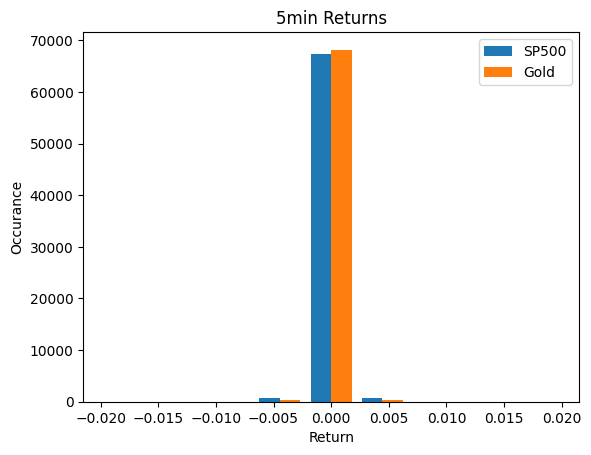

In [ ]:
plot_histograms(feature_futures_5min, name)

 ## **Regime Classification**

### 1-Dimensional Regime Classification

In [ ]:
feature_futures_5min

,Volume,Close,Open,High,Low,Vwap,cor_vol_price,ret_break_vol,range_5m,mv_3hrs_5,crossing_mv,r_std_12hrs_5,r_skew_12hrs_5,r_kurt_12hrs_5,r_std_3hrs_5,r_skew_3hrs_5,r_kurt_3hrs_5,ret,Gold_ret
DateTimeLocal,,,,,,,,,,,,,,,,,,,
2021-06-30 12:00:00,5064.0,4284.25,4285.25,4285.25,4284.25,4284.810476,0.154492,0.0,0.000233,4283.430556,56.0,0.000292,-0.108644,1.584987,0.000357,0.393302,-0.441633,-0.000233,0.000510
2021-06-30 12:05:00,3983.0,4284.50,4285.25,4285.25,4284.50,4284.992405,0.081242,0.0,0.000175,4283.645833,57.0,0.000292,-0.112742,1.582625,0.000352,0.346571,-0.366429,0.000058,0.000623
2021-06-30 12:10:00,3397.0,4285.25,4284.75,4285.50,4284.75,4285.114513,-0.015903,0.0,0.000175,4283.916667,58.0,0.000292,-0.123311,1.561372,0.000348,0.271607,-0.302957,0.000175,0.000339
2021-06-30 12:15:00,5313.0,4286.25,4285.75,4286.25,4285.50,4285.806889,-0.147628,0.0,0.000175,4284.208333,59.0,0.000293,-0.135570,1.525572,0.000349,0.228183,-0.355703,0.000233,-0.000283
2021-06-30 12:20:00,6247.0,4284.75,4286.00,4286.00,4284.75,4285.312310,-0.337882,0.0,0.000292,4284.472222,59.0,0.000294,-0.120235,1.446536,0.000354,0.230084,-0.457833,-0.000350,-0.000057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24 16:35:00,1369.0,3908.75,3909.00,3909.50,3908.75,3909.041088,0.441184,0.0,0.000192,3898.722222,69.0,0.000871,3.211472,21.381134,0.000541,0.879745,1.391789,-0.000128,0.000000
2022-06-24 16:40:00,1300.0,3908.00,3909.25,3909.25,3908.00,3908.619808,0.408722,0.0,0.000320,3899.152778,69.0,0.000872,3.215393,21.370862,0.000533,1.024055,1.846359,-0.000192,0.000164
2022-06-24 16:45:00,2505.0,3907.75,3908.25,3908.25,3906.50,3907.437226,0.382549,0.0,0.000448,3899.638889,69.0,0.000871,3.216696,21.405022,0.000520,1.079724,2.103530,-0.000064,0.000000


In [ ]:
#Classification based on volatility quantiles
def volatility_regime_analysis(feature_futures_5min):
    """
    This function performs volatility regime analysis using the standard deviation of 5-min return of SP500 futures in 3 hours
    as a proxy for volatility and using the 33% and 67% quantiles of SD of 5-min return of SP500 futures in 3 hours to divide
    the regimes for volatility. It plots the return and standard deviation of SP500 futures in different volatility regimes and
    counts the number of ups and downs under certain volatility regimes.

    Parameters:
    -----------
    feature_futures_5min: pandas DataFrame
                          Input data containing the features and target for futures data

    Returns:
    --------
    None
    """
    # Use standard deviation of 5-min return of SP500 futures in 3 hours as a proxy for volatility
    # Use 33% 67% quantiles of SD of 5-min return of SP500 futures in 3 hours to divide the regimes for volatility
    filtered_data = feature_futures_5min.copy()
    y_binary = (filtered_data['ret'][1:] > 0).astype(int)
    X = filtered_data.copy()
    vola_split_1 = filtered_data.get('r_std_3hrs_5').quantile(1/3)
    vola_split_2 = filtered_data.get('r_std_3hrs_5').quantile(2/3)

    # Plotting return in different regimes
    plt.figure(figsize=(16,9))
    ax1 = plt.subplot(3,1,1)
    vola_1 = X[X['r_std_3hrs_5']<vola_split_1]
    vola_1y = y_binary[X['r_std_3hrs_5']<vola_split_1]
    vola_1['ret'].plot(title='Return of SP500 futures in low volatility regime')
    plt.subplot(312,sharex=ax1)
    vola_2 = X[(X['r_std_3hrs_5']>=vola_split_1)&(X['r_std_3hrs_5']< vola_split_2)]
    vola_2y = y_binary[(X['r_std_3hrs_5']>=vola_split_1)&(X['r_std_3hrs_5']< vola_split_2)]
    vola_2['ret'].plot(title='Return of SP500 futures in medium volatility regime')
    plt.subplot(313,sharex=ax1)
    vola_3 = X[X['r_std_3hrs_5']>= vola_split_2]
    vola_3y = y_binary[X['r_std_3hrs_5']>= vola_split_2]
    vola_3['ret'].plot(title='Return of SP500 futures in high volatility regime')

    # Plotting std in different regimes
    plt.figure(figsize=(16,9))
    ax1 = plt.subplot(3,1,1)
    vola_1['r_std_3hrs_5'].plot(title='Std of 5-min Return of SP500 futures in 3 hours in low volatility regime')
    plt.subplot(312,sharex=ax1)
    vola_2['r_std_3hrs_5'].plot(title='Std of 5-min Return of SP500 futures in 3 hours in medium volatility regime')
    plt.subplot(313,sharex=ax1)
    vola_3['r_std_3hrs_5'].plot(title='Std of 5-min Return of SP500 futures in 3 hours in high volatility regime')

    # Plotting std of 5-min return of SP500 futures in 3 hours in all regimes
    feature_futures_5min['r_std_3hrs_5'].plot(title='Std of 5-min Return of SP500 futures in 3 hours')

    # Print the threshold values
    print(f'The first threshold for volatility regime: {vola_split_1:.5f}')
    print(f'The second threshold for volatility regime: {vola_split_2:.5f}')

    vola_1 = X[X['r_std_3hrs_5']<vola_split_1]

    vola_2 = X[(X['r_std_3hrs_5']>=vola_split_1)&(X['r_std_3hrs_5']< vola_split_2)]

    vola_3 = X[X['r_std_3hrs_5']>= vola_split_2]

    vola_1_ret = (vola_1['ret'] > 0).astype(int).value_counts().sort_index().rename('Lower than 33%(Volatility)')
    vola_2_ret = (vola_2['ret'] > 0).astype(int).value_counts().sort_index().rename('Between 33% and 67%(Volatility)')
    vola_3_ret = (vola_3['ret'] > 0).astype(int).value_counts().sort_index().rename('Higher than 67%(Volatility)')
    counts_df = pd.concat([vola_1_ret, vola_2_ret, vola_3_ret], axis=1)

    # Plot the number of ups and downs under certain volatility regimes
    counts_df.plot.bar(figsize=(10,6), subplots=True)
    plt.xlabel('Down and up')
    counts_df.plot.bar(figsize=(10,6), layout=(2,2))
    plt.xlabel('Down and up')



The first threshold for volatility regime: 0.00033
The second threshold for volatility regime: 0.00063


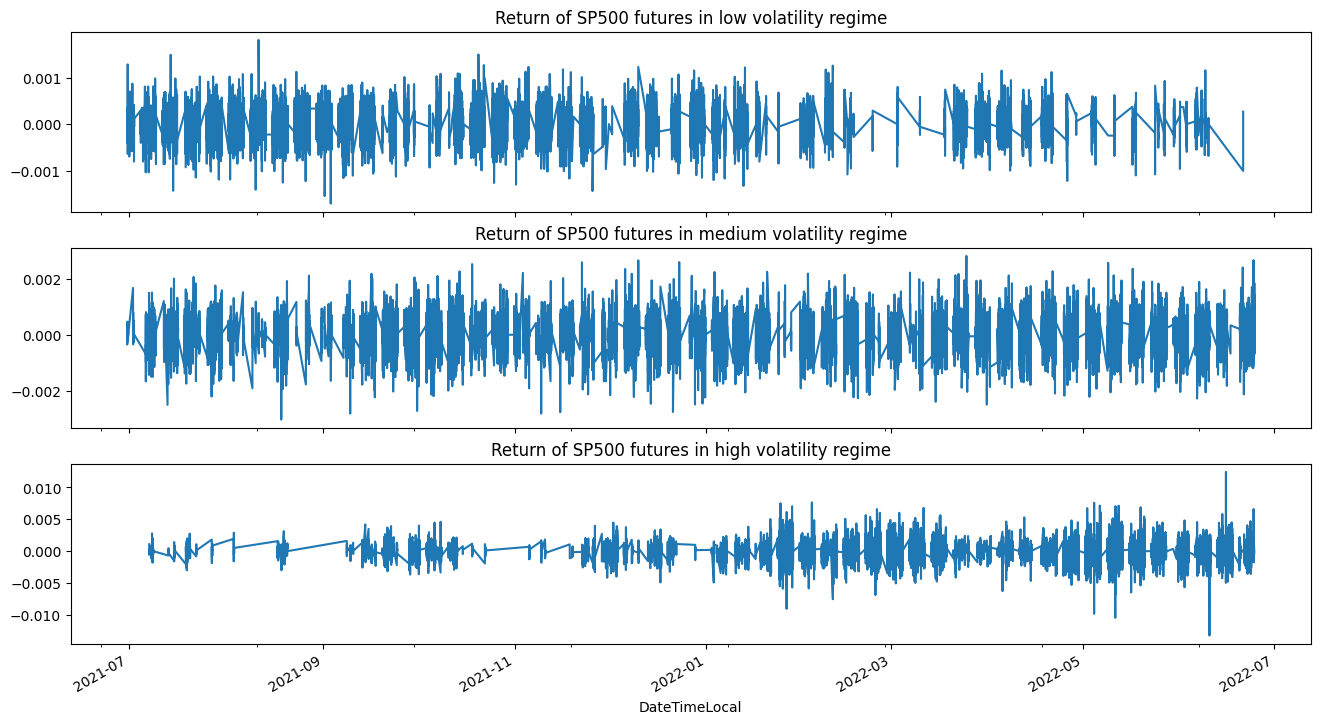

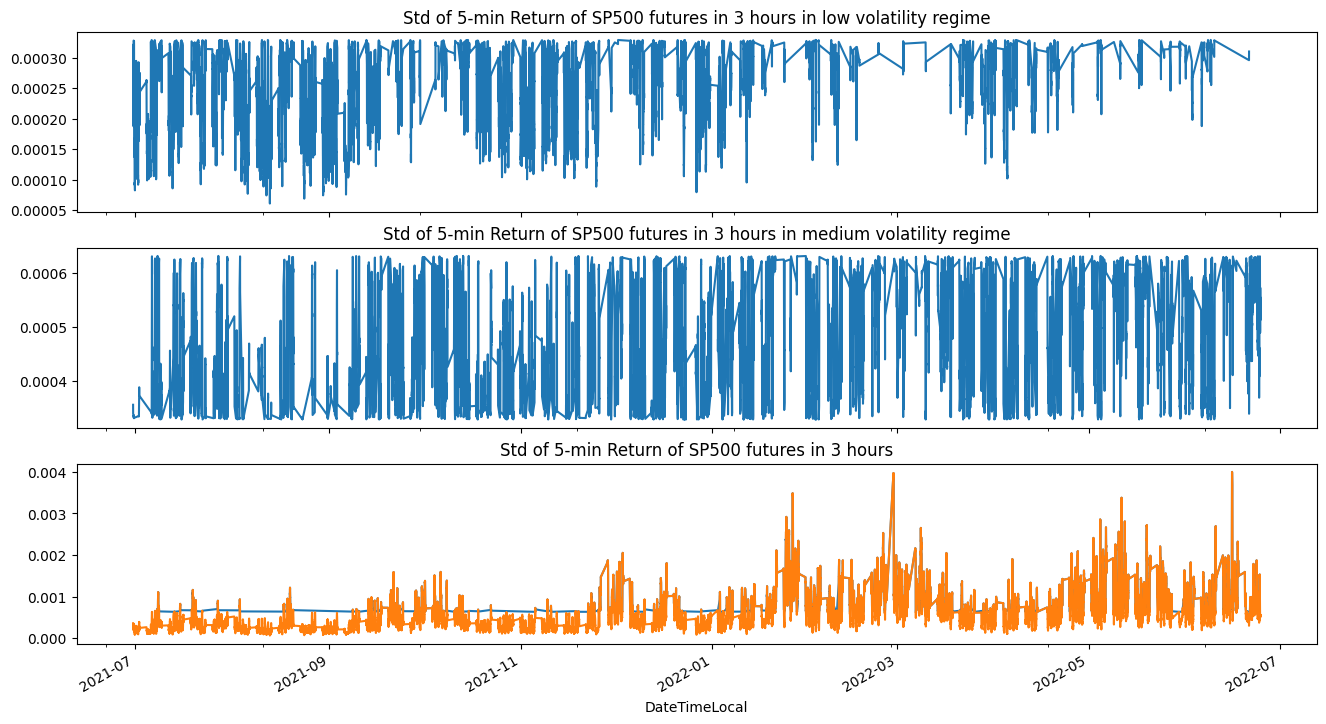

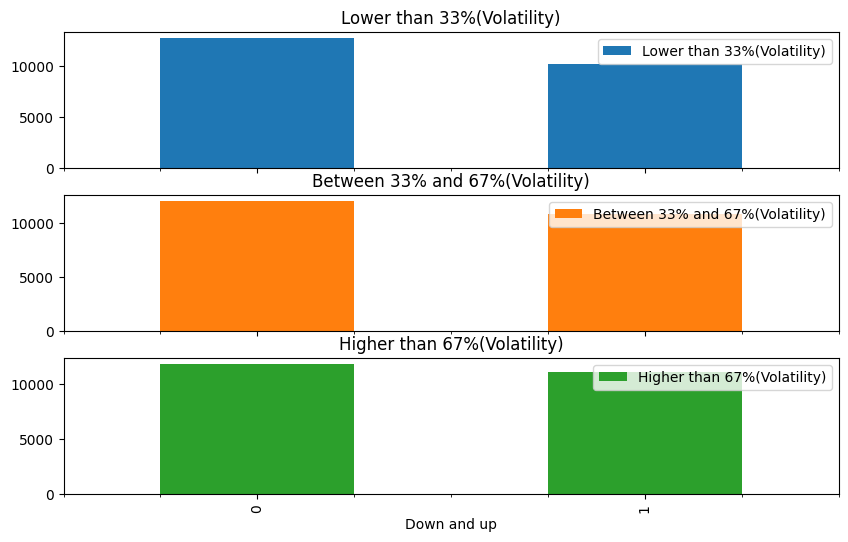

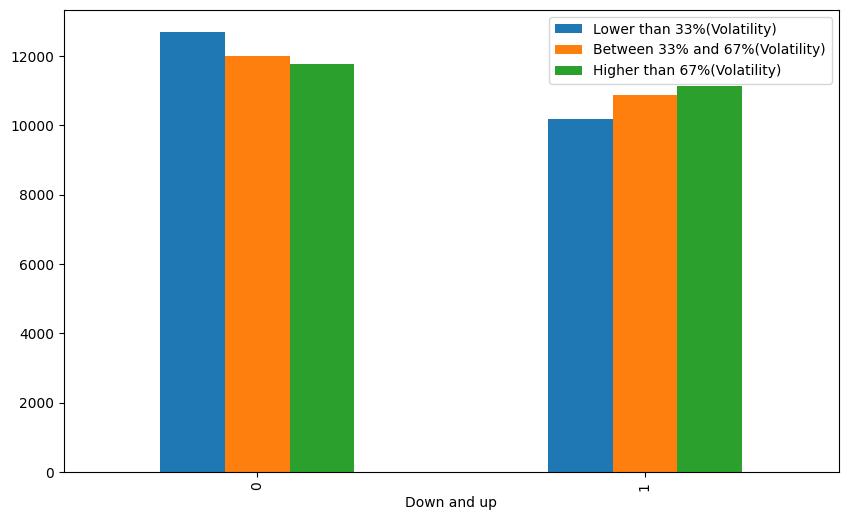

In [ ]:
volatility_regime_analysis(feature_futures_5min)

### Gaussian Mixture Model for Regime Classification

In [ ]:
def gaussian_mixture_model(df, n):
    """
    Perform Gaussian Mixture Model (GMM) for volatility regime analysis and visualize the results.

    Args:
        df (pd.DataFrame): Input DataFrame containing the features.
        n (int): Number of components in the GMM.

    Returns:
        None
    """
    # Extract the relevant features from the DataFrame
    features = df[['r_skew_3hrs_5', 'r_std_3hrs_5', 'range_5m']]

    # Fit the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n)
    gmm.fit(features)

    # Generate regime probabilities for each data point
    regime_probs = gmm.predict_proba(features)

    # Get the most probable regime for each data point
    regime_labels = np.argmax(regime_probs, axis=1)

    # Plot the results
    plt.scatter(range(len(features)), features.iloc[:,0], c=regime_labels, cmap='viridis', s=0.8)
    plt.title('Volatility Regime Analysis')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.show()

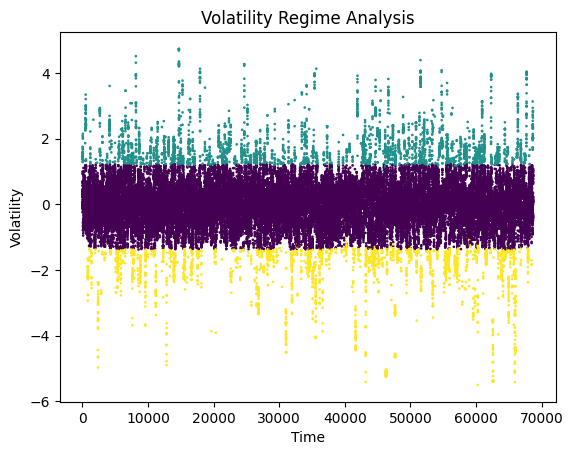

In [ ]:
gaussian_mixture_model(feature_futures_5min, n=3)

## **Prediction**

### Forming training and testing set

In [ ]:

def train_test_split_custom(data, target_col, test_size, random_state=666, shuffle=False):
    """
    Splits the input data into training and testing sets based on the given test size.

    Args:
    - data (pd.DataFrame): The feature matrix along with the target variable
    - target_col (str): The name of the target column
    - test_size (float): The proportion of the data to be used for testing
    - random_state (int): The random seed for reproducibility
    - shuffle (bool): Whether or not to shuffle the data before splitting

    Returns:
    - X_train (pd.DataFrame): The feature matrix for the training data
    - X_test (pd.DataFrame): The feature matrix for the testing data
    - y_train (pd.Series): The target variable for the training data
    - y_test (pd.Series): The target variable for the testing data
    """
    y_binary = data[target_col].shift(-1).dropna()
    y_binary = (y_binary > 0).astype(int)
    X = data.copy()
    X_train, X_test, y_train, y_test = train_test_split(X.iloc[:len(X)-1, :], y_binary, test_size=test_size,
                                                        random_state=random_state, shuffle=shuffle)
    return X_train, X_test, y_train, y_test


### **Random Forests**


In [ ]:
# Desision tree and random forest classifier
def run_classifier(clf, X_train, X_test, y_train, y_test):
    """
    Run a classifier model, such as Decision Tree or Random Forest, on the given training and testing data.

    Args:
        clf: Classifier model object that implements the fit and predict methods.
        X_train (pd.DataFrame): Training data features.
        X_test (pd.DataFrame): Testing data features.
        y_train (pd.Series): Training data labels.
        y_test (pd.Series): Testing data labels.

    Returns:
        Tuple: Accuracy scores for training and testing data, and signals generated by the classifier.

    """
    # Fit the random forest model to the training data
    clf.fit(X_train, y_train)

    # Make predictions on the training and testing data
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    # Calculate accuracy scores
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    # Create signals for in-sample and out-of-sample data
    signal_in_sample_rf = pd.DataFrame(y_pred_train, index=X_train.index, columns=['signal'])
    signal_out_sample_rf = pd.DataFrame(y_pred_test, index=X_test.index, columns=['signal'])

    # Save accuracy scores
    acc_df = pd.DataFrame(columns=['Random Forest'])
    acc_df['Random Forest'] = [acc_train, acc_test]

    # Run portfolio backtest
    backtest(signal_in_sample_rf, signal_out_sample_rf, 'Portfolio Returns by using signal from Random Forest Classifier', mxd=True, display=True)

    print("in sample", acc_train)
    print("out-of-sample", acc_test)
    # Return accuracy scores and signals
    return acc_df, signal_in_sample_rf, signal_out_sample_rf




In [ ]:
def plot_feature_importance(tree_clf, X_train, n_features):
    """
    Plot the feature importance of a decision tree classifier.

    Args:
        tree_clf (DecisionTreeClassifier): The trained decision tree classifier.
        X_train (pd.DataFrame): The feature matrix of the training data.
        n_features (int): The number of top features to consider.

    Returns:
        None

    Raises:
        None

    """

    # Calculate feature importance
    feature_importance = pd.Series(tree_clf.feature_importances_, index=X_train.columns)

    # Select the top n_features features
    top_features = feature_importance.sort_values(ascending=False).iloc[:n_features].sort_values()

    # Create a figure
    plt.figure(figsize=(8, 6))

    # Plot the top features as horizontal bar chart
    top_features.plot.barh(title='Classifier')

    # Set the x-axis label
    plt.xlabel('Feature Importance')

    # Set the y-axis label
    plt.ylabel('Features')

    # Display the plot
    plt.show()


#### Train test split

In [ ]:
def form_dataset(df, test_size):
    """
    Form a test dataset by splitting the input DataFrame into training and testing sets.

    Args:
        df (pd.DataFrame): Input DataFrame containing the data.
        test_size (float): The proportion of the data to be used for testing.

    Returns:
        tuple: A tuple containing the training and testing data and labels: (X_train, X_test, y_train, y_test).
    """
    filtered_data = df.copy()

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split_custom(filtered_data, 'ret', test_size,
                                                               random_state=666, shuffle=False)

    return X_train, X_test, y_train, y_test

In [ ]:
# Form dataset
X_train, X_test, y_train, y_test = form_dataset(feature_futures_5min, 0.4)

# Form another test dataset for overfitting detection
X_train25, X_test25, y_train25, y_test25 = form_dataset(feature_futures_5min, 0.25)

In [ ]:
# Get the overlapping section
filtered_data = feature_futures_5min.copy()
y_binary = (filtered_data['ret'][1:] > 0).astype(int)
overlap_start = X_test.index[0]
overlap_end = X_train25.index[-1]
y_overlap = y_binary[overlap_start:overlap_end]
y_overlap

DateTimeLocal
2022-02-01 06:10:00    0
2022-02-01 06:15:00    0
2022-02-01 06:20:00    1
2022-02-01 06:25:00    0
2022-02-01 06:30:00    1
                      ..
2022-03-24 21:45:00    1
2022-03-24 21:50:00    1
2022-03-24 21:55:00    0
2022-03-24 22:00:00    0
2022-03-24 22:05:00    0
Name: ret, Length: 10307, dtype: int64

#### Decision Tree Classifier

Max drawdown in sample -0.692777933186477
Max drawdown out sample -76.5807456772227
Sharpe in sample: 0.7665732103870461
Sharpe out sample: -0.001323384787865281
in sample 0.9538883229030224
out-of-sample 0.5030744042204839
Max drawdown in sample -13.917310545021792
Max drawdown out sample -802.4716714866154
Sharpe in sample: 0.744417415451721
Sharpe out sample: 0.0018533479242418918
in sample 0.968505617759494
out-of-sample 0.5034928396786588


(   Random Forest
 0       0.968506
 1       0.503493,
                      signal
 DateTimeLocal              
 2021-06-30 12:00:00       1
 2021-06-30 12:05:00       1
 2021-06-30 12:10:00       1
 2021-06-30 12:15:00       0
 2021-06-30 12:20:00       0
 ...                     ...
 2022-03-24 21:45:00       1
 2022-03-24 21:50:00       0
 2022-03-24 21:55:00       0
 2022-03-24 22:00:00       0
 2022-03-24 22:05:00       0
 
 [51533 rows x 1 columns],
                      signal
 DateTimeLocal              
 2022-03-24 22:10:00       1
 2022-03-24 22:15:00       1
 2022-03-24 22:20:00       0
 2022-03-24 22:25:00       1
 2022-03-24 22:30:00       1
 ...                     ...
 2022-06-24 16:30:00       1
 2022-06-24 16:35:00       1
 2022-06-24 16:40:00       0
 2022-06-24 16:45:00       1
 2022-06-24 16:50:00       1
 
 [17178 rows x 1 columns])

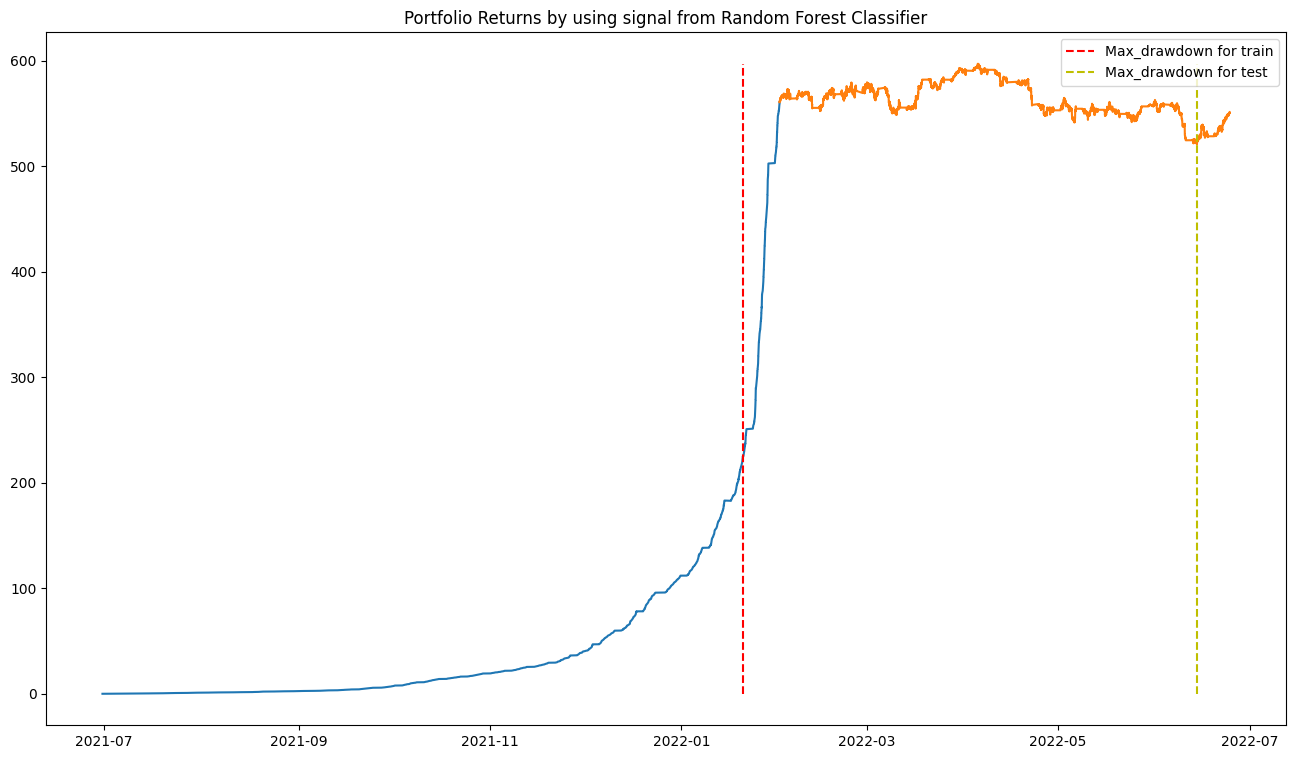

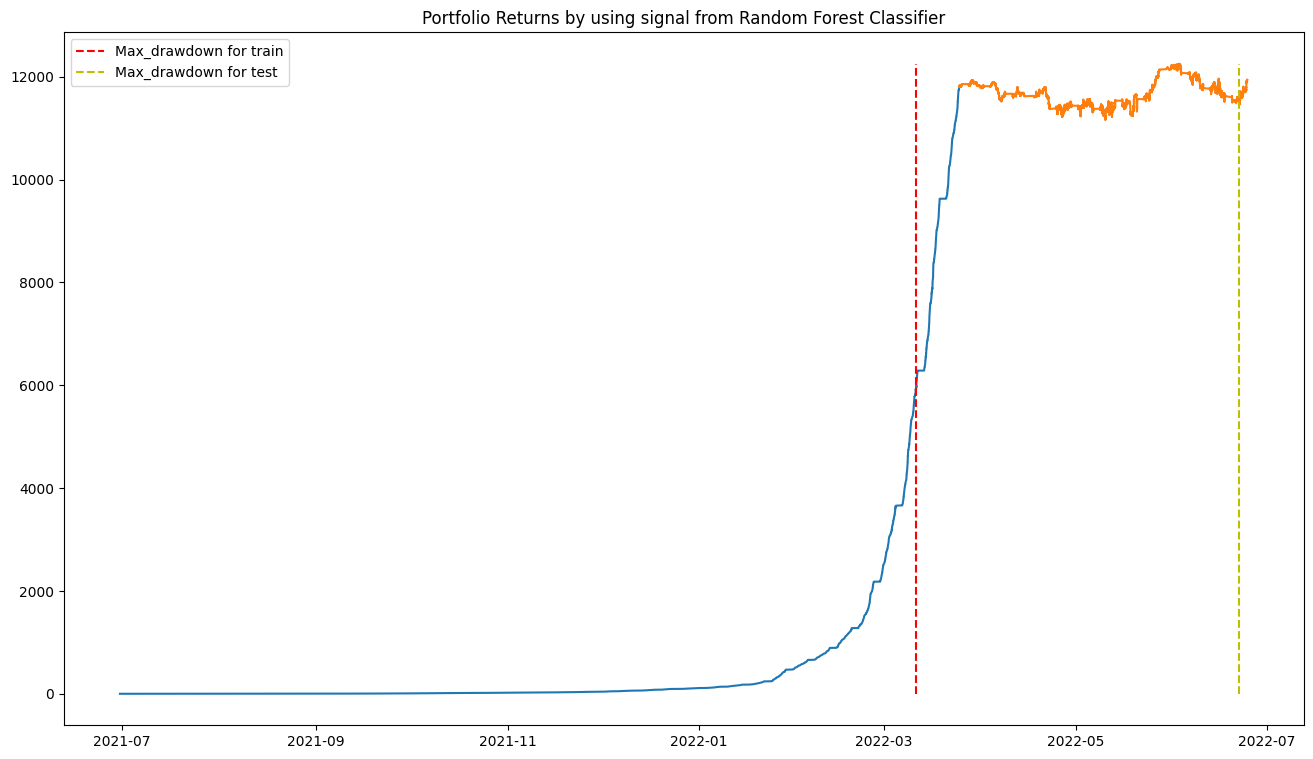

In [ ]:
# Use Decision Tree Classifier
dt_clf = DecisionTreeClassifier(max_depth=35)

# with test size 0.4
run_classifier(dt_clf,X_train, X_test, y_train, y_test)

# with test size 0.25
run_classifier(dt_clf,X_train25, X_test25, y_train25, y_test25)

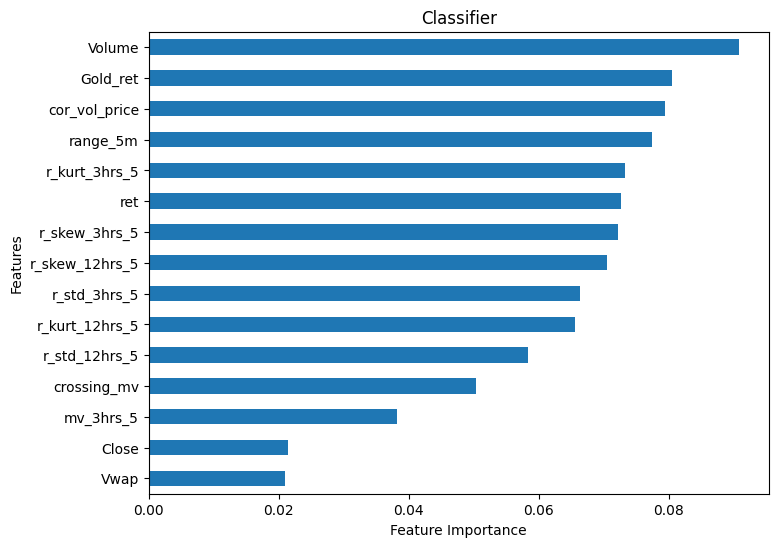

In [ ]:
# Feature importance
plot_feature_importance(dt_clf, X_train, n_features=15)

#### Random Forest Classifier


Max drawdown in sample -0.8849460291324363
Max drawdown out sample -95.7500956633595
Sharpe in sample: 0.7760723717049998
Sharpe out sample: -0.003929132793700766
in sample 0.9531606267889197
out-of-sample 0.5053665635801347
Max drawdown in sample -17.20913701742029
Max drawdown out sample -1626.911052622072
Sharpe in sample: 0.745612010980809
Sharpe out sample: -0.009999624307352956
in sample 0.9372635010575747
out-of-sample 0.4988939341017581


(   Random Forest
 0       0.937264
 1       0.498894,
                      signal
 DateTimeLocal              
 2021-06-30 12:00:00       1
 2021-06-30 12:05:00       1
 2021-06-30 12:10:00       1
 2021-06-30 12:15:00       0
 2021-06-30 12:20:00       1
 ...                     ...
 2022-03-24 21:45:00       1
 2022-03-24 21:50:00       1
 2022-03-24 21:55:00       0
 2022-03-24 22:00:00       0
 2022-03-24 22:05:00       0
 
 [51533 rows x 1 columns],
                      signal
 DateTimeLocal              
 2022-03-24 22:10:00       1
 2022-03-24 22:15:00       0
 2022-03-24 22:20:00       0
 2022-03-24 22:25:00       0
 2022-03-24 22:30:00       0
 ...                     ...
 2022-06-24 16:30:00       1
 2022-06-24 16:35:00       1
 2022-06-24 16:40:00       0
 2022-06-24 16:45:00       1
 2022-06-24 16:50:00       1
 
 [17178 rows x 1 columns])

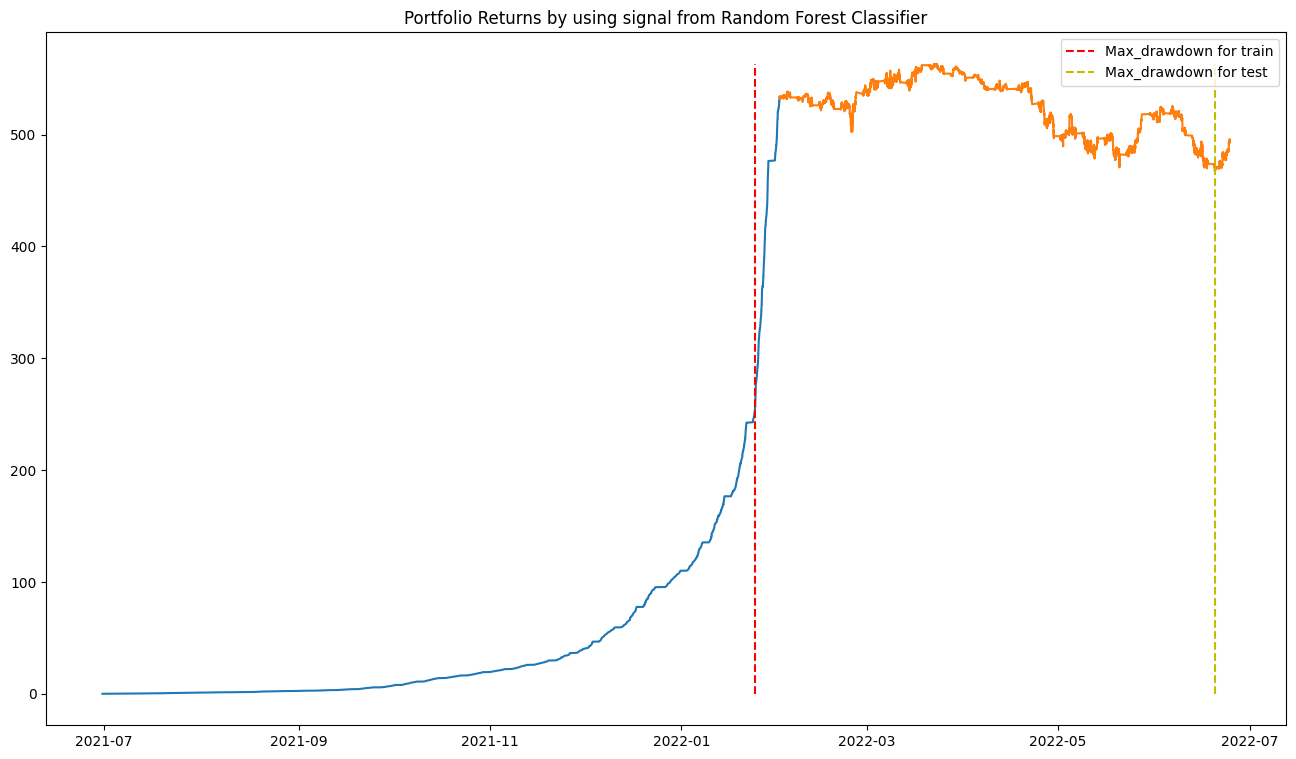

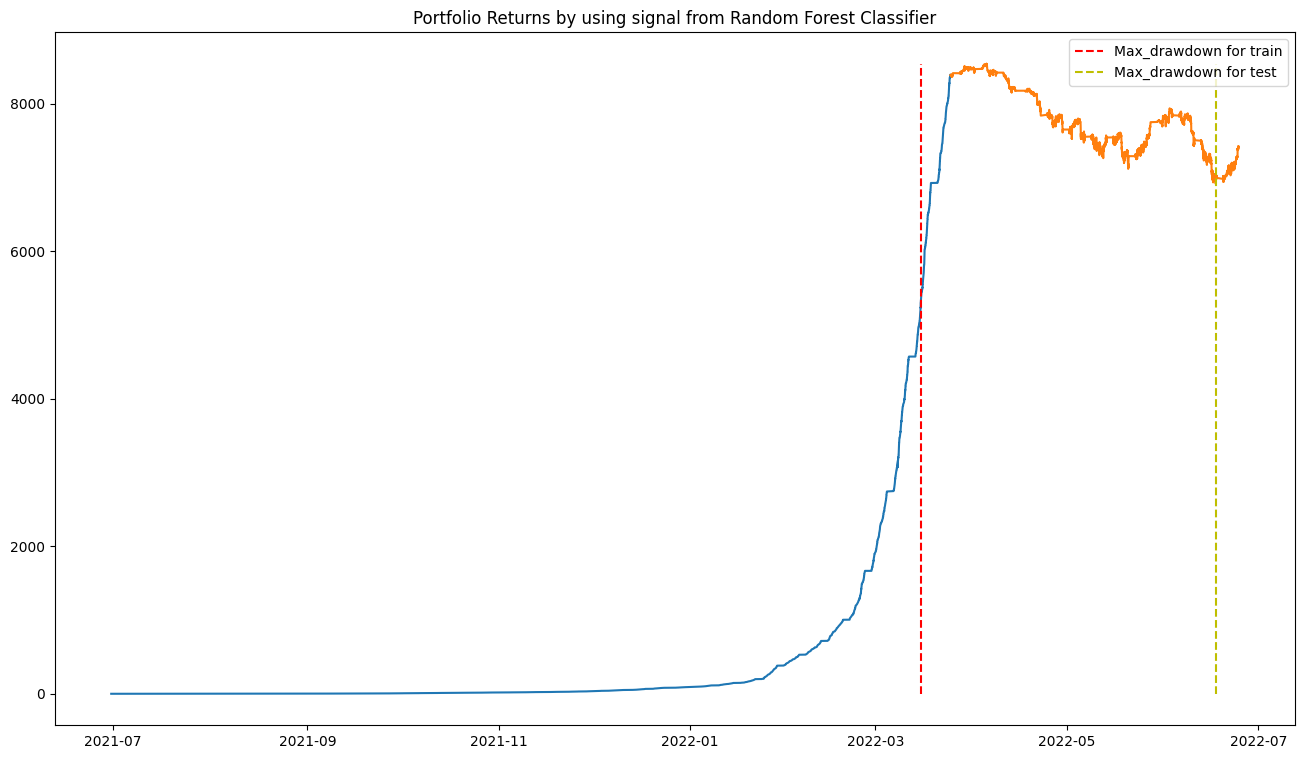

In [ ]:
# Use Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=30, max_leaf_nodes=2500, random_state=42)

# with test size 0.4
run_classifier(rf_clf,X_train, X_test, y_train, y_test)

# with test size 0.25
run_classifier(rf_clf,X_train25, X_test25, y_train25, y_test25)

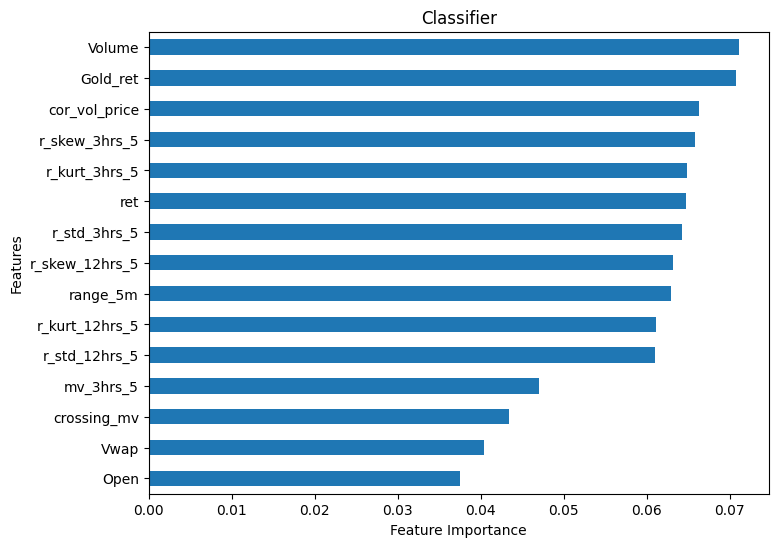

In [ ]:
# Feature importance
plot_feature_importance(rf_clf, X_train, n_features=15)